2024-03-28 16:41:53.125149: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 16:42:19.135081: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


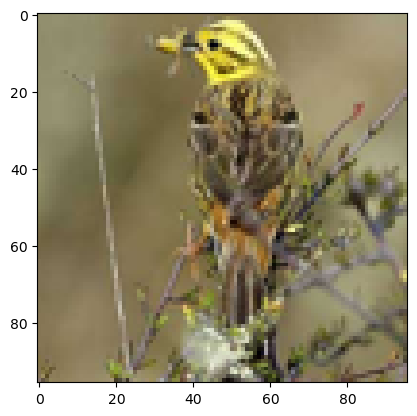

In [1]:
import numpy as np
import tensorflow as tf
import os


# 바이너리 파일에서 데이터 로딩 함수
def load_stl10_dataset(data_path):
    with open(data_path, 'rb') as file:
        data = np.fromfile(file, dtype=np.uint8)
    images = np.reshape(data, (-1, 3, 96, 96))
    images = np.transpose(images, (0, 3, 2, 1))  # TensorFlow에서 사용하기 위해 축 변경
    return images

# 데이터 전처리 함수
def preprocess_images(images):
    images = tf.cast(images, tf.float32)
    images = images / 255.0  # 정규화
    return images

# 예시: 데이터셋 압축 해제 및 로딩

# 이미지 로딩 (예시로 훈련 데이터 로딩을 보여줍니다)

images_path = os.path.join('../data/processed', 'train_X.bin')
images = load_stl10_dataset(images_path)

# 이미지 전처리
images = preprocess_images(images)

# 데이터 배치 및 셔플링 (TensorFlow Dataset API 사용)
# dataset = tf.data.Dataset.from_tensor_slices(images)
# dataset = dataset.shuffle(1000).batch(32)

# visualize
import matplotlib.pyplot as plt
plt.imshow(images[0])

In [22]:
# 파라미터 크기 확인
import tensorflow as tf
from tensorflow.keras import layers, models

from tensorflow.keras import models, layers

def residual_block(x, filters):
    """Depthwise 및 Pointwise Convolution을 사용한 잔차 블록."""
    # 입력과 동일한 차원의 출력을 생성하기 위해, 필터 수에 맞는 1x1 합성곱 레이어로 shortcut 경로 생성
    shortcut = layers.Conv2D(filters, (1, 1), padding='same')(x)

    # Depthwise Convolution
    x = layers.DepthwiseConv2D((3, 3), activation='relu', padding='same')(x)

    # Pointwise Convolution
    x = layers.Conv2D(filters, (1, 1), activation='relu', padding='same')(x)

    # 입력(x)과 shortcut을 더함
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x


def CNN(input_shape=(96, 96, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    # 첫 번째 합성곱 레이어
    x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    # 잔차 블록 추가
    x = residual_block(x, 256)
    x = layers.MaxPooling2D((2, 2))(x)

    x = residual_block(x, 512)
    x = layers.MaxPooling2D((2, 2))(x)

    x = residual_block(x, 1024)
    x = layers.MaxPooling2D((2, 2))(x)

    x = residual_block(x, 2048)
    x = layers.MaxPooling2D((2, 2))(x)

    # # 전역 평균 풀링과 분류 레이어
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    # dropout 추가
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes)(x)

    # 각주 부분은 GlobalAveragePooling2D를 사용하지 않고 Flatten과 Dense 레이어를 사용한 경우
    # x = layers.Flatten()(x)
    # x = layers.Dense(64, activation='relu')(x)
    # outputs = layers.Dense(num_classes)(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


model = CNN()
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_111 (Conv2D)            (None, 94, 94, 64)   1792        ['input_15[0][0]']               
                                                                                                  
 max_pooling2d_60 (MaxPooling2D  (None, 47, 47, 64)  0           ['conv2d_111[0][0]']             
 )                                                                                                
                                                                                                  
 depthwise_conv2d_40 (Depthwise  (None, 47, 47, 64)  640         ['max_pooling2d_60[0][0]']

In [24]:
# EfficientNet 모델 불러오기
model = tf.keras.applications.EfficientNetB0()

# ResNet101 모델 구조 요약
model.summary()
# 가중치 크기 확인


21834768/21834768 [==============================] - 2s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_17[0][0]']               
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                    